In [957]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy as copy

In [958]:
import numpy as np
np.random.seed(1123)
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = 2 * X.flatten() + np.random.normal(0, 1, size=100)


X = (X - X.min()) / (X.max() - X.min())*2 - 1

In [959]:
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2)

In [960]:
class Node:
    def __init__(self, threshold=None, value=None, leftChild=None, rightChild=None, feature=None):
        self.leftChild = leftChild
        self.rightChild = rightChild
        self.threshold = threshold
        self.value = value
        self.feature = feature

class decisionTreeRegressor:
    def __init__(self, minSamplesSplit, minSamplesLeaf, maxDepth, X, y, features=None):
        '''
        minSamplesSplit -> amt samples needed to consider node for being split
        minSamplesLeaf -> amt samples needed in a leaf after a split
        '''
        self.minSamplesSplit = minSamplesSplit # amt samples needed to consider node for being split
        self.minSamplesLeaf = minSamplesLeaf # amt samples needed in a leaf after a split
        self.maxDepth = maxDepth
        self.X = X
        self.y = y

        if features is None:
            self.features = range(self.X.shape[1])
        else:
            self.features = features

        self.root = Node()

    def printTree(self):
        def recursePrint(node, depth):
            indent = "  " * depth
            if node.value is not None:
                print(f"{indent}Leaf -> Predict {node.value}")
                return
            print(f"{indent}if x[{node.feature}] <= {node.threshold}:")
            recursePrint(node.leftChild, depth + 1)
            print(f"{indent}else:")
            recursePrint(node.rightChild, depth + 1)

        recursePrint(self.root, 0)

    def createTree(self, curNode:Node, depth, subset):
        if depth > self.maxDepth or len(subset) <= self.minSamplesSplit:
            return Node(value=self.meanTarget(subset))
        parentMse = self.mse(subset)

        logs = []
        for feature in self.features:
            for threshold in range(subset.shape[0]):
                threshold = subset[threshold, feature]
                leftSubset, rightSubset = self.split(subset, feature, threshold)

                if len(leftSubset) >= self.minSamplesLeaf and len(rightSubset) >= self.minSamplesLeaf:
                    weightedMse = (len(leftSubset)/len(subset))*(self.mse(leftSubset)) \
                    + (len(rightSubset)/len(subset))*(self.mse(rightSubset))
                
                    
                    informationGain = parentMse - weightedMse
                    logs.append((feature, threshold, informationGain))
        
        if not logs:
            # becomes a leaf node
            return Node(value=self.meanTarget(subset))

        logs.sort(key=lambda x: x[-1], reverse=True)
        best = logs[0]

        leftSubset, rightSubset = self.split(subset, best[0], best[1])

        curNode.threshold = best[1]
        curNode.feature = best[0]

        curNode.leftChild, curNode.rightChild = self.createTree(Node(), depth+1, leftSubset), self.createTree(Node(), depth+1, rightSubset)
        return curNode

    def meanTarget(self, subset):
        return np.mean(subset[:, -1])

    def split(self, subset, feature, threshold):
        left = np.array(np.empty((0, subset.shape[1])))
        right = np.array(np.empty((0, subset.shape[1])))
        for row in range(subset.shape[0]):
            item = subset[row, feature]
            
            if item <= threshold:
                left = np.vstack((left, np.expand_dims(subset[row], 0)))
            else:
                right = np.vstack((right, np.expand_dims(subset[row], 0)))

        return [left, right]
    
    def mse(self, subset):
        # look at the y values
        y = subset[:, -1]
        mean = np.mean(y)
        return np.mean((y-mean)**2)

    def predict(self, x):
        if x.shape == (self.X.shape[1],):
            # only one data point to predict
            x = np.expand_dims(x, 0)

        predictions = np.array([])
        for xInput in x:
            curNode = self.root
            while curNode.value is None:
                # print(curNode.threshold, curNode.feature, curNode.value)
                
                if xInput[curNode.feature] >= curNode.threshold:
                    curNode = curNode.rightChild
                else:
                    curNode = curNode.leftChild
            predictions = np.append(predictions, curNode.value)
        return predictions
    
    def fit(self):
        subset = np.concatenate((self.X, self.y.reshape(-1, 1)), axis=1)

        self.root = self.createTree(self.root, 0, subset)

In [961]:
dtr = decisionTreeRegressor(minSamplesSplit=3, minSamplesLeaf=3, maxDepth=10, X=xTrain, y=yTrain)
dtr.fit()

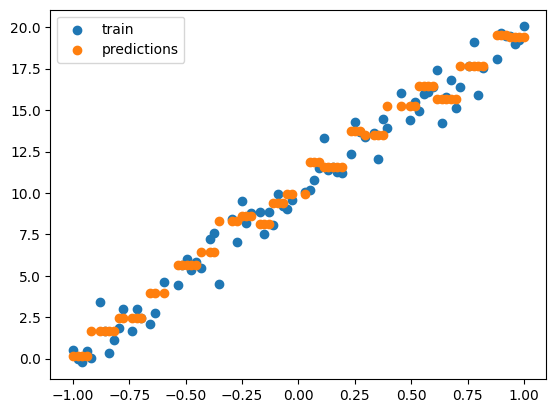

In [962]:
plt.scatter(xTrain, yTrain, label='train')
plt.scatter(xTrain, dtr.predict(xTrain), label='predictions')
plt.legend()
plt.show()

In [963]:
dtr.printTree()

if x[0] <= 0.05050505050505061:
  if x[0] <= -0.5353535353535354:
    if x[0] <= -0.9191919191919192:
      Leaf -> Predict 0.16280187406409424
    else:
      if x[0] <= -0.6565656565656566:
        if x[0] <= -0.797979797979798:
          Leaf -> Predict 1.675611028159595
        else:
          Leaf -> Predict 2.433382626471264
      else:
        Leaf -> Predict 3.940816537478502
  else:
    if x[0] <= -0.3535353535353536:
      if x[0] <= -0.43434343434343436:
        Leaf -> Predict 5.654541521393766
      else:
        Leaf -> Predict 6.432017719158066
    else:
      if x[0] <= -0.11111111111111105:
        if x[0] <= -0.17171717171717182:
          if x[0] <= -0.2525252525252525:
            Leaf -> Predict 8.325104323428812
          else:
            Leaf -> Predict 8.602593958113061
        else:
          Leaf -> Predict 8.153243551381408
      else:
        if x[0] <= -0.0505050505050505:
          Leaf -> Predict 9.396808773269422
        else:
          Leaf -> Predict 

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:04<00:00, 21.82it/s]


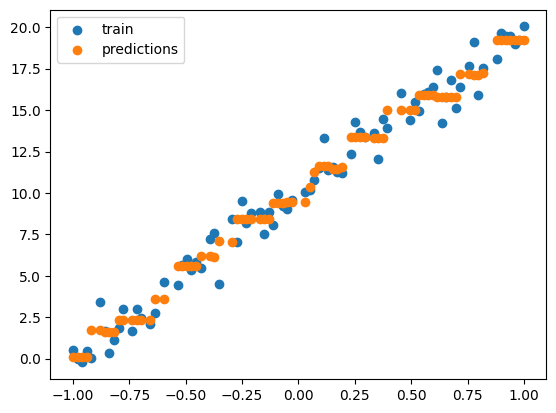

In [964]:
class GradientBoostingTree:
    def __init__(self, X, y, nEstimators, maxDepth, lr, minSamplesSplit, minSamplesLeaf):
        self.X, self.y = X, y
        self.nEstimators = nEstimators
        self.maxDepth = maxDepth
        self.lr = lr
        self.minSamplesSplit, self.minSamplesLeaf = minSamplesSplit, minSamplesLeaf 
        self.treePath = []

    def computeGradient(self, yTrue, yPred):
        # pseudo-residuals
        return yTrue - yPred
    
    def trainWeakLearnerOnResiduals(self, predictions):
        residuals = self.computeGradient(self.y, predictions)
        weakLearner = decisionTreeRegressor(self.minSamplesSplit, self.minSamplesLeaf, self.maxDepth, self.X, residuals)
        weakLearner.fit()
        self.treePath.append(copy(weakLearner))
        return weakLearner.predict(self.X)
    
    def fit(self):
        self.initPredictions = np.full(self.y.shape[0], np.mean(self.y))
        for _ in tqdm(range(self.nEstimators)):
            self.initPredictions += self.lr * self.trainWeakLearnerOnResiduals(self.initPredictions)  

    def predict(self, x):
        pred = np.mean(self.y)
        for tree in self.treePath:
            pred += self.lr * tree.predict(x)
        return pred

gbr = GradientBoostingTree(
    X=xTrain, y=yTrain, 
    nEstimators=100, 
    maxDepth=1, 
    lr=0.05, 
    minSamplesSplit=3, 
    minSamplesLeaf=3
)
gbr.fit()
plt.scatter(xTrain, yTrain, label='train')
plt.scatter(xTrain, gbr.predict(xTrain), label='predictions')
plt.legend()
plt.show()

In [965]:
yPred = dtr.predict(xTrain).astype(int)


trainDTRError = np.mean((yTrain-yPred)**2)
trainDTRError

0.9876306347189969

In [966]:
yPred = dtr.predict(xTest).astype(int)
testDTRError = np.mean((yTest-yPred)**2)
testDTRError

2.1159174125436504

In [967]:
yPred = gbr.predict(xTrain).astype(int)

trainGbrError = np.mean((yTrain-yPred)**2)
trainGbrError

0.9527021737170912

In [968]:
yPred = gbr.predict(xTest).astype(int)
testGbrError = np.mean((yTest-yPred)**2)
testGbrError

2.098125479445465

In [969]:
print(f'''
                    DTC           GBR
Train Error    ->   {format(trainDTRError, ".2f")}          {format(trainGbrError, ".2f")}
Test  Error    ->   {format(testDTRError, ".2f")}          {format(testGbrError, ".2f")}
''')


                    DTC           GBR
Train Error    ->   0.99          0.95
Test  Error    ->   2.12          2.10

